# Computational Physics
## Monte Carlo Integration

<img src="https://upload.wikimedia.org/wikipedia/commons/8/84/Pi_30K.gif" width=400px>

## Last Time

- Simpson's rule
- Improper and divergent integrals
- `scipy.integrate`

## Today
- Error scaling for high dimensional quadrature
- Integration using random numbers


## Setting up the Notebook

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.style.use('notebook');
%config InlineBackend.figure_format = 'retina'
colors = ["#2078B5", "#FF7F0F", "#2CA12C", "#D72827", "#9467BE", "#8C574B",
            "#E478C2", "#808080", "#BCBE20", "#17BED0", "#AEC8E9", "#FFBC79", 
            "#98E08B", "#FF9896", "#C6B1D6", "#C59D94", "#F8B7D3", "#C8C8C8", 
           "#DCDC8E", "#9EDAE6"]

## Beyond One-Dimension

Until now we have performed numerical integrals by approximating them as a disccrete sum over equally sized panels with width:

\begin{equation}
\Delta x = \frac{b-a}{N}.
\end{equation}

### Rectangular

\begin{equation}
\int_a^b f(x) dx = \frac{b-a}{N} \sum_{j=0}^{N-1} f\left(a + \frac{j(b-a)}{N}\right) + \mathrm{O}\left(\frac{1}{N}\right). 
\end{equation}

### Trapezoidal

\begin{equation}
\int_a^b f(x) dx = \frac{b-a}{N}\left [\frac{1}{2}f(a) +  \sum_{j=1}^{N-1} f\left(a + \frac{j(b-a)}{N}\right) +\frac{1}{2}f(b)\right] + \mathrm{O}\left(\frac{1}{N^2}\right). 
\end{equation}

### Simpson

\begin{equation}
\int_a^b f(x) dx = \frac{b-a}{3N}\left \{ f(a) +  \sum_{j=1}^{N-1}\left[3-(-1)^j\right] f\left(a + \frac{j(b-a)}{N}\right) +f(b)\right\} + \mathrm{O}\left(\frac{1}{N^4}\right). 
\end{equation}

We now ask how these methods scale in higher dimensions, i.e.:

\begin{equation}
I = \int dx_1 \int dx_2 \cdots \int dx_d\, f(\vec{x}).
\end{equation}

We will need to break up $d$-dimensional space into a grid with $N$ panels in each dimension which will form $M = N^d$ total points at which we must evaulate our function.  If we say a quadrature method is $k^{th}$ order of the error scales as $N^{-k}$ then using this method in $d$ dimensions will lead to an error:

\begin{equation}
\mathrm{Error} \sim \frac{1}{N^k} = \frac{1}{M^{k/d}}.
\end{equation}

<br />
<div class="span alert alert-danger">
This is bad!  An order $k$-scheme in 1-dimension is an order $k/d$ scheme in $d$-dimensions.
</div>

## Integrals as Averages

Consider a $d$-dimensional region of space $\Omega$ and a function $f: \mathbb{R}^d \to \mathbb{R}$.  We are interested in the integral:

\begin{equation}
\int_{\Omega} d\vec{x}\, f(\vec{x})
\end{equation}

We can re-write the integral as an average of the function over the region $\Omega$ with the uniform probability:

\begin{equation}
P(\vec{x}) = \frac{1}{\int_\Omega d\vec{x}}
\end{equation}

which gives: 

\begin{equation}
\langle f \rangle_\Omega =  \int_{\Omega} d\vec{x}\, P(\vec{x}) f(\vec{x}).
\end{equation}

If we select $M$ points at random from the uniform distribution $\vec{x}_i \in \mathcal{U}_\Omega$ then we can approximate the average as:

\begin{equation}
I = \langle f \rangle_\Omega \approx \frac{1}{M} \sum_{i=0}^{M-1} f(\vec{x}_i).
\end{equation}

It is just the *average* of the function at a discrete set of points selected uniformly in the region.

<div class="span alert alert-success">
<h2>Programming challenge </h2>
Use Monte Carlo integration to aproximate the integral of the $2$-dimensional function $f(\vec{x})$ on the unit square.
</div>

\begin{equation}
I = \int_{-1/2}^{1/2} dx \int_{-1/2}^{1/2} dx \mathrm{e}^{-x^2 -y^2 -x^2 y^2}
\end{equation}

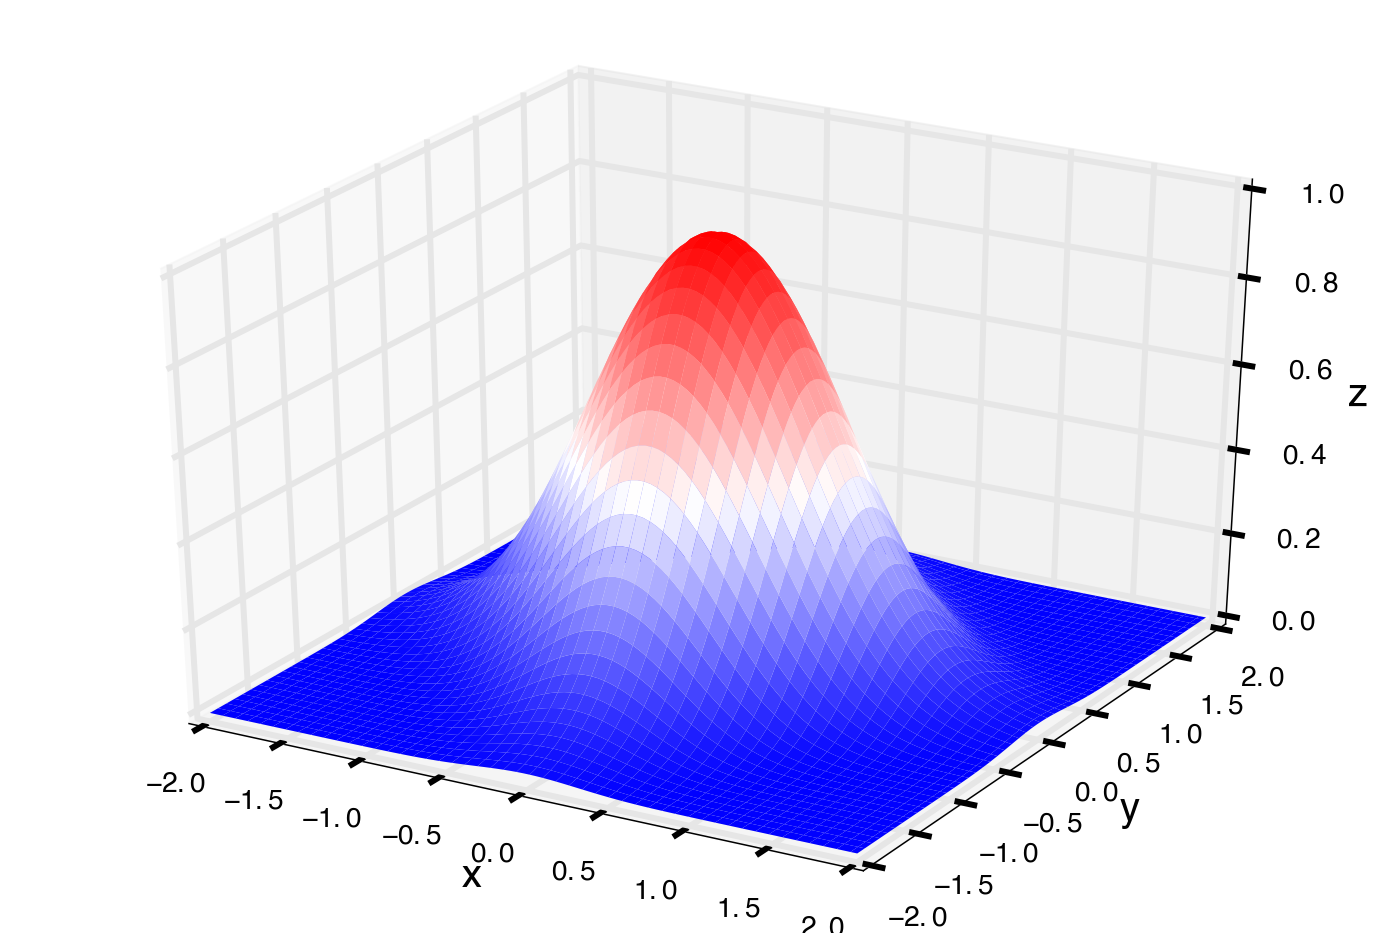

In [2]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12,8))
ax = fig.gca(projection='3d')
X, Y = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))
f = np.exp(-X**2 - Y**2 - X**2*Y**2)
surf = ax.plot_surface(X, Y, f, rstride=2, cstride=2, cmap='bwr', linewidth=0, antialiased=True)

ax.set_xlabel('x',labelpad=14)
ax.set_ylabel('y',labelpad=14)
ax.set_zlabel('z',labelpad=14)

[t.label.set_fontsize(14) for caxis in [ax.xaxis, ax.yaxis, ax.zaxis] for t in caxis.get_major_ticks()];

In [4]:
def f(x,y):
    return np.exp(-x**2 - y**2 - x**2*y**2)

# Number of MC points
M = 10000

# initialize the integral
I = 0

for i in range(M):
    x = -0.5 + np.random.random()
    y = -0.5 + np.random.random()
    I += f(x,y)
    
I /= M

print('I = ',I)

I =  0.84446714582


## Computing the Error

The error in computing the integral is now stochastic (as opposed to systematic).  How can we estimate it?

Suppose we repeat the process of performing the integral many times, i.e. we generate many sets of $M$ points.  The error will be related to the variance of the resulting values for the average.

\begin{align*}
\sigma_I^2 &= \langle I^2\rangle - \langle I\rangle^2 \newline
&= \left\langle \left(\frac{1}{M} \sum_{i=0}^{M-1} f_i\right)^2\right\rangle - \left( \left\langle \frac{1}{M} \sum_{i=0}^{M-1} f_i\right\rangle\right)^2 \newline
&= \frac{1}{M^2}\left[\sum_{i=0}^{M-1} \sum_{j=0}^{M-1}\langle f_i f_j \rangle - \sum_{i=0}^{M-1} \sum_{j=0}^{M-1} \langle f_i \rangle\langle f_j \rangle\right] \newline
&= \frac{1}{M^2}\left[\sum_{i=0}^{M-1} \langle f_i^2 \rangle + \sum_{i\ne j}\langle f_i f_j \rangle - \sum_{i=0}^{M-1} \sum_{j=0}^{M-1} \langle f_i \rangle\langle f_j \rangle\right] \newline
\end{align*}

Now, for completely uncorrelated measurements:

\begin{equation}
\langle f_i f_j \rangle = \langle f_i \rangle \langle f_j \rangle
\end{equation}

and we are left with:

\begin{equation}
\sigma_I^2 = \frac{1}{M^2} \sum_{i=0}^{M-1} \left( \langle f_i^2 \rangle - \langle f_i \rangle^2\right).
\end{equation}

However, $\langle \cdots \rangle$ manes that we are sampling the function of a large number of *sets* of numbers $\left\{\vec{x}_i\right\}$ so:

\begin{equation}
\langle f_i \rangle = \langle f \rangle
\end{equation}

and we are left with:

\begin{equation}
\sigma_I^2 =  \frac{1}{M} \left(\langle f_i^2 \rangle - \langle f_i \rangle^2 \right) = \frac{\sigma_f^2}{M}.
\end{equation}

This is just a result of the [central limit theorem](https://en.wikipedia.org/wiki/Central_limit_theorem) and shows that the error in our Monte Carlo integration technicle is:

\begin{equation}
\mathrm{O}\left(\frac{1}{M^{1/2}}\right).
\end{equation}

Recall that we found for $d$-dimensions, the trapezoidal method had an $\mathrm{O}(M^{-2/d})$ error, thus Monte Carlo beats trapezoidal for $d>4$.

Let's check the error scaling for our previous integral.

In [5]:
def Monte_Carlo_integration(f,M):
    r = -0.5 + np.random.random([M,2])
    return np.average(f(r[:,0],r[:,1]))

exact = 0.846008

# we consider different numbers of MC points and many trials
M = np.array(range(1,100,1))
trials = 1000

I = np.zeros([trials,M.size])

# for each trial and number of points, compute the itegral
for trial in range(trials):
    for j,cM in enumerate(M):
        I[trial,j] = Monte_Carlo_integration(f,cM)

# compute the average and standard error in the integral
aveI = np.average(I,axis=0)
errI = np.std(I,axis=0)/np.sqrt(trials)

# the error in the integral
error = np.abs(aveI - exact)

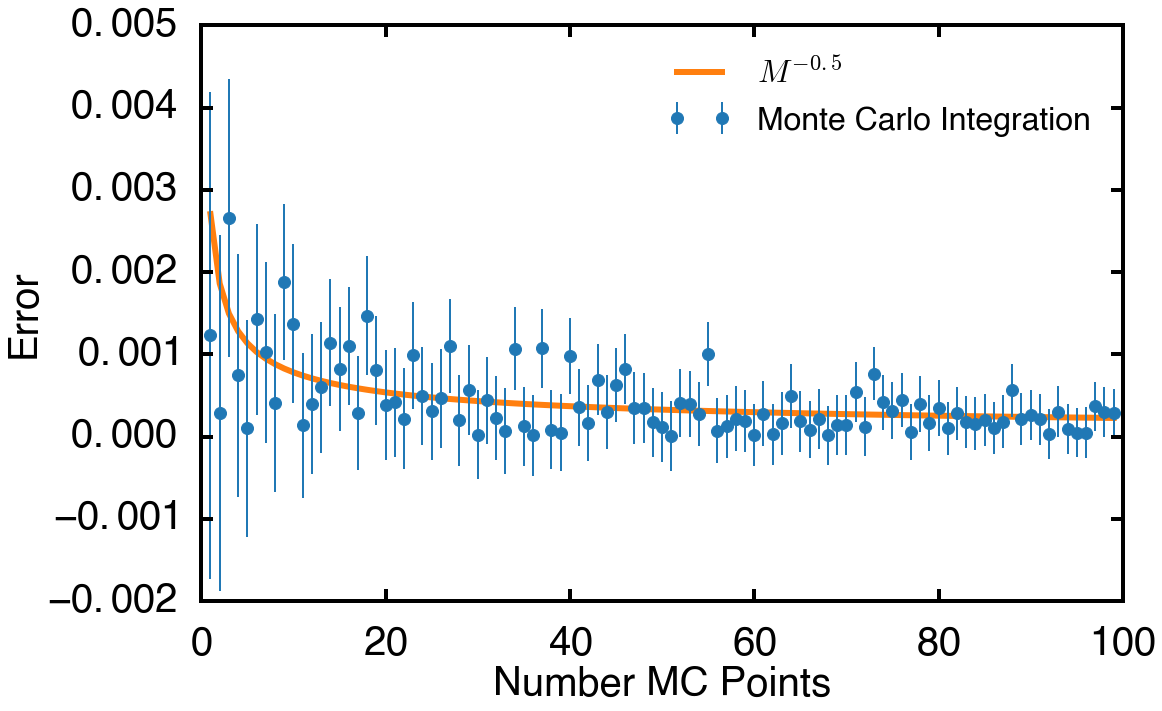

In [8]:
from scipy.optimize import curve_fit

def fit_func(x,*a):
    return a[0]/x**a[1]

# fit to extract the form of the error
a1,a1_cov = curve_fit(fit_func,M,error,sigma=errI,p0=(1,1))
plt.plot(M,fit_func(M,*a1), color=colors[1], zorder=0, label=r'$M^{-%2.1f}$'%a1[1])

# compare with the calculated value
plt.errorbar(M,error,yerr=errI, marker='o', capsize=0, elinewidth=1, mec=colors[0], 
             mfc=colors[0], ms=6, linestyle='None', ecolor=colors[0], label='Monte Carlo Integration')

plt.ylabel('Error')
plt.xlabel('Number MC Points')
plt.legend(loc='upper right')